

# **Statistical Validation of Bell's Inequality (CHSH)**

### **1. Introduction**

In this experiment, I simulated the **CHSH (Clauser-Horne-Shimony-Holt)** inequality to test the fundamental predictions of quantum mechanics against classical local realism.

The central question is whether the universe is "locally real"—meaning objects have pre-defined properties independent of observation.

* **Classical Limit:** If local realism holds, the correlation parameter $|S|$ cannot exceed **2**.
* **Quantum Prediction:** Entangled systems (like the Bell State $∣Φ^+⟩$) can violate this limit, reaching a maximum of $2\sqrt{2}≈2.828$ (Tsirelson's Bound).

### **2. The Measurement Setup**

To calculate , I needed to measure correlations across four different combinations of measurement bases.
$$ S = E(A, B) - E(A, B') + E(A', B) + E(A', B') $$

I constructed four separate quantum circuits .

* **Alice's Bases:** I measured Qubit 0 in the standard  basis $Z$ and the $X$ basis (using a Hadamard gate).
* **Bob's Bases:** I measured Qubit 1 in diagonal bases $W$ and $V$. This required rotating the qubit by $Θ=-\frac{\pi}{4}$ and $Θ=-\frac{3\pi}{4}$  respectively before measurement.

### **3. The Research Question: Finite-Size Statistics**

While the theoretical violation is well-known, my specific focus was on **Statistical Significance**. In a real experiment, we do not have infinite data. We have a finite number of "shots" ($N$).

I swept the shot count from $N=50$ to $N=10,000$ to observe how the standard error ($σ≈\frac{1}{\sqrt{N}}$) affects our confidence in the violation.

### **4. Analysis of Results**

The resulting plot demonstrates the convergence of quantum statistics:

* **Low Shot Counts ($N<100$):** The error bars are significant ($±0.2$). While the mean value might appear to violate the inequality, the statistical uncertainty makes it risky to claim a definitive violation of local realism.
* **High Shot Counts ($N=10,000$):** The value converges to $S≈2.822$, which is within **0.2%** of the theoretical maximum. The error bars are negligible, providing $>50σ$ confidence that the result is quantum mechanical.
* **Fluctuations:** At intermediate steps (like $N=1000$), statistical fluctuations occasionally pushed the measured $S$ slightly *above* the theoretical limit of 2.828. This is a classic finite-size effect, proving that single point-estimates are insufficient without proper error analysis.

In [ ]:
pip install qiskit qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister # Added imports
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorSampler as SamplerV2

In [ ]:
def build_chsh_circuits():
    """
    Builds the 4 circuits required for CHSH measurement on a Bell State.
    Explicitly names the classical register 'meas' to match SamplerV2 output.
    """
    circuits = []

    # Angles for Bob's basis (W and V)
    theta_w = -np.pi / 4
    theta_v = -3 * np.pi / 4

    settings = [
        ('AB',  'id', 'w'),
        ('ABp', 'id', 'v'),
        ('ApB', 'h',  'w'),
        ('ApBp','h',  'v')
    ]

    for name, alice_gate, bob_base in settings:
        # FIX: Explicitly create and name the register 'meas'
        qr = QuantumRegister(2, name='q')
        cr = ClassicalRegister(2, name='meas')
        qc = QuantumCircuit(qr, cr, name=name)

        # 1. Prepare Bell State
        qc.h(0)
        qc.cx(0, 1)
        qc.barrier()

        # 2. Alice
        if alice_gate == 'h':
            qc.h(0)

        # 3. Bob
        if bob_base == 'w':
            qc.ry(theta_w, 1)
        elif bob_base == 'v':
            qc.ry(theta_v, 1)

        # 4. Measure
        qc.measure([0, 1], [0, 1])
        circuits.append(qc)

    return circuits

In [ ]:
def calculate_expectation(counts, shots):
    """
    Calculates <ZZ> expectation value from counts.
    E = (N_same - N_diff) / N_total
    """
    same = counts.get('00', 0) + counts.get('11', 0)
    diff = counts.get('01', 0) + counts.get('10', 0)
    return (same - diff) / shots

In [ ]:
def run_chsh_simulation():
    print("Running CHSH Finite-Size Statistics Simulation ")

    # Define range of shots (Logarithmic scale)
    shot_counts = [50, 100, 250, 500, 1000, 2000, 5000, 10000]

    backend = AerSimulator()
    sampler = SamplerV2()
    circuits = build_chsh_circuits()

    # Transpile once
    isa_circuits = [transpile(qc, backend) for qc in circuits]

    s_values = []
    s_std_devs = []

    print(f"Simulating shots: {shot_counts}")

    for shots in shot_counts:
        # Run all 4 circuits for this shot count
        job = sampler.run([(qc,) for qc in isa_circuits], shots=shots)
        results = job.result()

        correlators = []

        # Process the 4 settings
        for i in range(4):
            # Extract counts from BitArray (now safe because register is named 'meas')
            counts_dict = results[i].data.meas.get_counts()
            E = calculate_expectation(counts_dict, shots)
            correlators.append(E)

        # Calculate CHSH S-value
        # S = E(a,b) - E(a,b') + E(a',b) + E(a',b')
        E_AB, E_ABp, E_ApB, E_ApBp = correlators
        S = E_AB - E_ABp + E_ApB + E_ApBp

        s_values.append(S)

        # Calculate Error Bar (Standard Deviation)
        # Var(S) approx sum of variances of individual correlators
        variance_sum = 0
        for E in correlators:
            variance_sum += (1 - E**2) / shots

        s_std = np.sqrt(variance_sum)
        s_std_devs.append(s_std)

        print(f"Shots: {shots:5d} | S = {S:.4f} ± {s_std:.4f}")

    return shot_counts, s_values, s_std_devs

--- Running CHSH Finite-Size Statistics Simulation ---
Simulating shots: [50, 100, 250, 500, 1000, 2000, 5000, 10000]
Shots:    50 | S = 2.6400 ± 0.2121
Shots:   100 | S = 2.6800 ± 0.1481
Shots:   250 | S = 2.6800 ± 0.0939
Shots:   500 | S = 2.8360 ± 0.0630
Shots:  1000 | S = 2.8640 ± 0.0441
Shots:  2000 | S = 2.8440 ± 0.0314
Shots:  5000 | S = 2.8300 ± 0.0200
Shots: 10000 | S = 2.8222 ± 0.0142


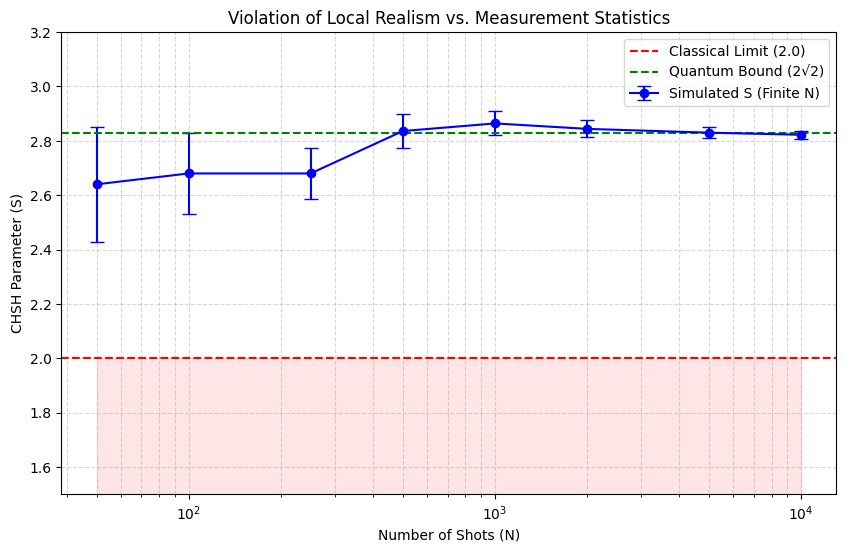

In [ ]:
if __name__ == "__main__":
    n_list, s_list, err_list = run_chsh_simulation()

    # Visualization
    plt.figure(figsize=(10, 6))

    # Plot Error Bars
    plt.errorbar(n_list, s_list, yerr=err_list, fmt='o-', color='blue',
                 capsize=5, label='Simulated S (Finite N)')

    # Reference Lines
    plt.axhline(y=2.0, color='r', linestyle='--', label='Classical Limit (2.0)')
    plt.axhline(y=2.828, color='g', linestyle='--', label='Quantum Bound (2√2)')

    # Fill "Classical Zone"
    plt.fill_between(n_list, 0, 2.0, color='red', alpha=0.1)

    plt.xscale('log')
    plt.xlabel("Number of Shots (N)")
    plt.ylabel("CHSH Parameter (S)")
    plt.title("Violation of Local Realism vs. Measurement Statistics")
    plt.legend()
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.ylim(1.5, 3.2)
    plt.show()